In [1]:
# This code works in Python 3.10.6
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
import torch_geometric.transforms as T
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
from torch_geometric.datasets import IMDB
import os
import os.path as osp

## IMDB

In [3]:
dataset = IMDB(root='./imdb_data')
data = dataset[0]
data

Extracting imdb_data/raw/IMDB_processed.zip
Processing...
Done!


HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278]
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)

In [4]:
#Original movie node features
movie = data['movie'].x.tolist()
movie_df = pd.DataFrame(movie)
movie_df['class'] = data['movie'].y.tolist()
np.unique(movie_df)

array([0., 1., 2., 3., 4., 5.])

### Bag-of-Words features of Movie node

In [5]:
movie_class0 = movie_df[movie_df['class'] == 0].drop(['class'], axis = 1)
movie_class0.head()

,0,1,2,3,4,5,6,7,8,9,...,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
movie_class1 = movie_df[movie_df['class'] == 1].drop(['class'], axis = 1)
movie_class1.head()

,0,1,2,3,4,5,6,7,8,9,...,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
movie_class2 = movie_df[movie_df['class'] == 2].drop(['class'], axis = 1)
movie_class2.head()

,0,1,2,3,4,5,6,7,8,9,...,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
def sample_features(model,node_type, n_samples):

    smpls = model.sample(n_samples)
    print("no of class {} node samples - {}".format(node_type, n_samples))
    return smpls[0]

In [9]:
def fit_sample_gm(df_class, node_type, n_samples):
    #fit
    model = GaussianMixture(n_components=1, covariance_type='full', random_state = 0)
    model.fit(df_class)
    #print("Mean for nodetype", node_type,model.means_)
    #sample
    smpls = sample_features(model, node_type, n_samples)
    new_features_dict[node_type] = smpls

In [10]:
def feature_selection(df_sampled):
    col_sum = df_sampled.sum(axis=0)
    sorted_colsum = sorted(col_sum, reverse=True)

    index_list = []
    for i in sorted_colsum[:1]:
        index_list.append(list(col_sum).index(i))
        imp_feat = df_sampled[index_list].reset_index(drop=True)
        return imp_feat, index_list

In [11]:
def count_plot(df,ind):

    fig, ax = plt.subplots(figsize=(7, 7))
    sns.countplot(data=df,x=ind,width=0.3,ax=ax)
    #https://www.geeksforgeeks.org/how-to-show-values-on-seaborn-barplot/
    for i in ax.containers:
        ax.bar_label(i,fontsize=15)
    plt.xticks(fontsize=15)

    plt.yticks(fontsize=15)
    plt.xlabel('feature values',fontsize=15)
    plt.ylabel('no. of samples',fontsize=15)

    plt.show()

In [12]:
def cosine_sim(original,sampled):
    return cosine_similarity(np.array(original), np.array(sampled))

### Fit Gaussian Mixture Models to 4 Movie node classes

In [13]:
new_features_dict = {}

In [14]:
fit_sample_gm(movie_class0, 'movie0', movie_class0.shape[0])
fit_sample_gm(movie_class1, 'movie1', movie_class1.shape[0])
fit_sample_gm(movie_class2, 'movie2', movie_class2.shape[0])

no of class movie0 node samples - 1135
no of class movie1 node samples - 1584
no of class movie2 node samples - 1559


### Continuous features sampled using Gaussian Mixure Models

In [15]:
sampled0  = pd.DataFrame(new_features_dict['movie0'])
sampled0.head()

,0,1,2,3,4,5,6,7,8,9,...,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065
0,-0.023998,-0.000413,-0.000582,0.003266,-0.022176,0.000531,-0.001673,0.000318,-0.031963,0.017918,...,-0.021755,0.012424,-0.001806,-0.022918,-0.000012,-0.000191,-0.073211,0.063801,0.009512,0.010183
1,-0.051891,-0.000425,-0.000380,-0.021201,0.002239,0.000292,0.001694,-0.000807,-0.032935,-0.019009,...,-0.030974,-0.083880,-0.000641,0.048439,0.001695,0.001352,0.036734,0.081280,-0.002544,0.051308
2,-0.054967,0.000382,-0.000722,-0.052572,-0.000200,-0.001539,0.000449,-0.000321,0.046649,-0.026558,...,-0.030695,-0.048377,-0.000052,0.030178,0.000307,-0.000501,-0.004935,0.180858,0.024554,0.075811
3,0.027416,0.000495,0.000740,-0.029790,0.010182,0.000800,-0.000291,-0.001284,-0.047208,-0.004239,...,0.002364,-0.007637,0.001800,-0.015226,-0.000765,0.001023,-0.023752,-0.004989,0.042177,-0.004500
4,-0.018624,-0.000273,0.000876,0.043668,-0.041449,0.000813,-0.000301,-0.001833,0.032527,0.040124,...,-0.013142,0.016444,0.000695,0.070703,-0.000443,0.001534,0.016207,0.008614,0.045844,0.029966


In [16]:
sampled1  = pd.DataFrame(new_features_dict['movie1'])
sampled1.head()

,0,1,2,3,4,5,6,7,8,9,...,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065
0,-0.000147,-0.000887,0.054777,-0.006859,-0.000244,-0.033133,0.034367,0.001251,-0.006275,-0.000503,...,-0.043955,0.017430,0.038370,0.000033,-0.020384,0.000580,-0.000284,0.154666,0.137860,0.001630
1,0.000440,0.000576,-0.003166,0.037076,-0.000812,0.010758,-0.009746,-0.000055,-0.033271,-0.000872,...,0.063617,-0.027883,0.030258,0.001073,0.016457,-0.000814,0.000583,-0.041261,-0.007343,0.000118
2,-0.001463,0.000198,-0.051685,0.005744,-0.001166,0.025425,0.008871,0.001109,-0.020465,0.001449,...,0.035014,-0.094980,-0.027206,-0.000838,-0.011905,-0.000337,0.000093,-0.028834,-0.047837,0.000595
3,0.001795,-0.001345,0.013114,0.020088,-0.001372,0.002455,0.051376,-0.001697,-0.027983,0.001926,...,-0.041753,0.004483,-0.087690,0.001336,-0.001734,0.001886,0.000239,-0.183326,-0.012693,-0.001485
4,0.000490,0.000945,0.046191,0.017428,-0.000008,0.016009,-0.020556,-0.001213,0.005980,-0.000824,...,-0.008742,0.065793,0.042556,-0.001878,-0.064157,0.001849,0.001047,0.081763,-0.056603,-0.001613


In [17]:
sampled2  = pd.DataFrame(new_features_dict['movie2'])
sampled2.head()

,0,1,2,3,4,5,6,7,8,9,...,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065
0,0.000608,0.017419,-0.098374,0.036123,-0.005446,-0.000025,0.028436,0.006835,0.015712,0.000951,...,-0.001041,0.036100,0.086275,-0.000943,-0.000693,-0.007780,-0.000951,0.060014,0.000559,-0.001064
1,0.000590,0.051005,0.055802,-0.016308,0.023240,0.003948,0.004500,0.024214,-0.011282,-0.000964,...,-0.000848,0.043874,-0.005208,0.001172,-0.000604,0.047137,0.000101,0.030254,0.000747,0.000929
2,0.000563,-0.020294,0.005443,-0.013517,-0.002462,-0.037528,0.007386,-0.035331,-0.042429,0.000745,...,0.000224,0.057869,0.033869,0.020345,-0.000465,0.056184,0.000062,0.028268,0.000499,-0.000611
3,-0.000374,-0.014371,0.007729,0.019974,-0.000196,-0.027859,0.003460,0.004718,-0.011716,-0.000380,...,-0.000818,-0.075247,-0.007126,0.018972,-0.002201,0.003079,0.001887,-0.128013,-0.000224,0.000727
4,-0.000178,0.029325,0.015783,-0.002256,0.014038,-0.008642,0.019097,0.008338,-0.012489,0.001251,...,-0.000531,0.003851,-0.015369,0.013762,-0.001909,-0.019043,-0.000412,0.119082,-0.001118,0.000176


### Sampled continuous features are converted to discrete using a threshold

In [18]:
sampled_discrete_class0 = pd.DataFrame(sampled0).applymap(lambda x: 0.0 if x<0.5 else 1.0 if 0.75>=x<0.8 
                       else 2.0 if 0.8>=x<0.85 else 3.0 if 0.85>=x<0.9 
                       else 5.0 if 0.95>=x<0.99 else 0.0)
sampled_discrete_class0.head()

,0,1,2,3,4,5,6,7,8,9,...,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
sampled_discrete_class1 = pd.DataFrame(sampled1).applymap(lambda x: 0.0 if x<0.5 else 1.0 if 0.75>=x<0.8 
                       else 2.0 if 0.8>=x<0.85 else 3.0 if 0.85>=x<0.9  else 0.0)
sampled_discrete_class1.head()

,0,1,2,3,4,5,6,7,8,9,...,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
sampled_discrete_class2 = pd.DataFrame(sampled2).applymap(lambda x: 0.0 if x<0.5 else 1.0 if 0.75>=x<0.8 
                       else 2.0 if 0.8>=x<0.85 else 3.0 if 0.85>=x<0.9  else 0.0)
sampled_discrete_class2.head()

,0,1,2,3,4,5,6,7,8,9,...,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Comparison of real and synthetic distributions for the most important feature

Movie class 0

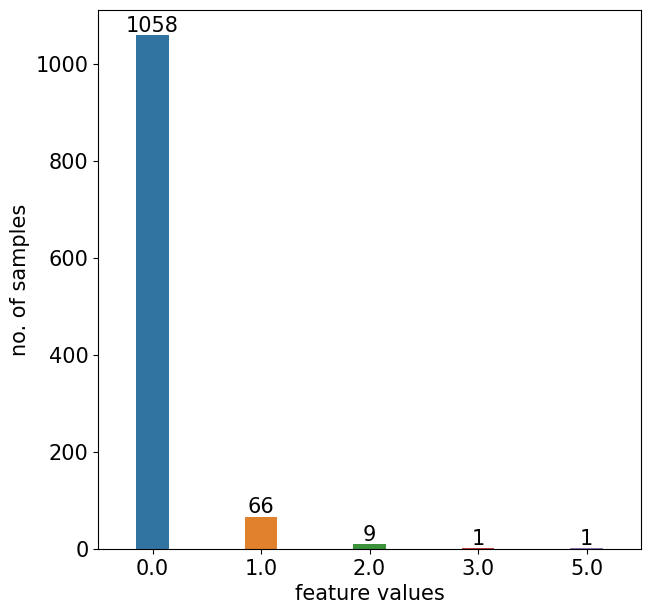

In [21]:
#Real
imp_feat0, index_list =feature_selection(movie_class0)
ind0 = index_list[0]
count_plot(movie_class0, ind0)

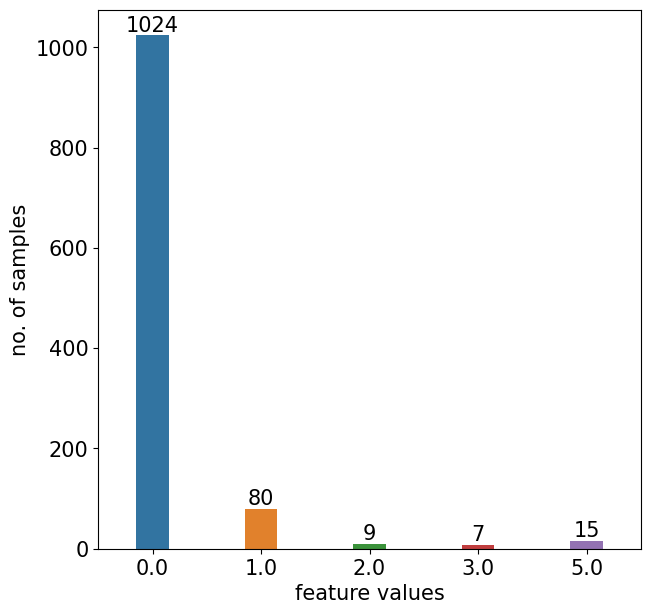

In [22]:
#Synthetic
imp_feat0, index_list =feature_selection(sampled_discrete_class0)
ind0 = index_list[0]
count_plot(sampled_discrete_class0, ind0)

Movie class 1

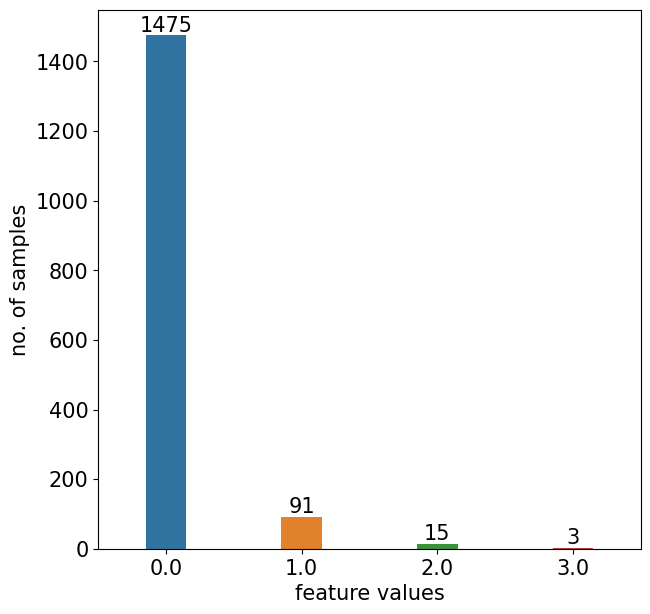

In [23]:
#Real
imp_feat1, index_list =feature_selection(movie_class1)
ind1 = index_list[0]
count_plot(movie_class1, ind1)

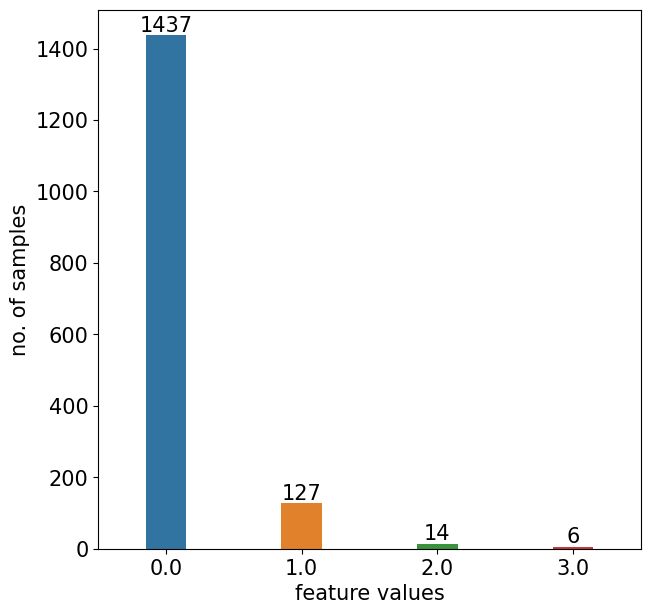

In [24]:
#Synthetic
imp_feat1, index_list =feature_selection(sampled_discrete_class1)
ind1 = index_list[0]
count_plot(sampled_discrete_class1, ind1)

Movie class 2

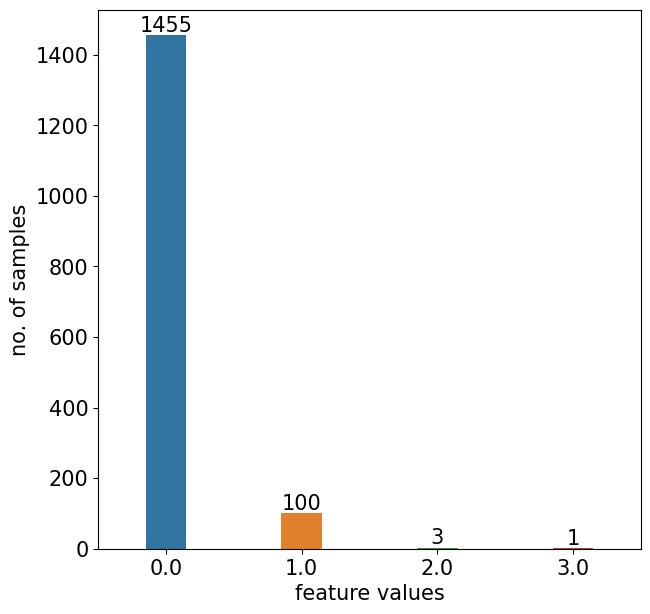

In [25]:
#Real
imp_feat2, index_list =feature_selection(movie_class2)
ind2 = index_list[0]
count_plot(movie_class2, ind2)

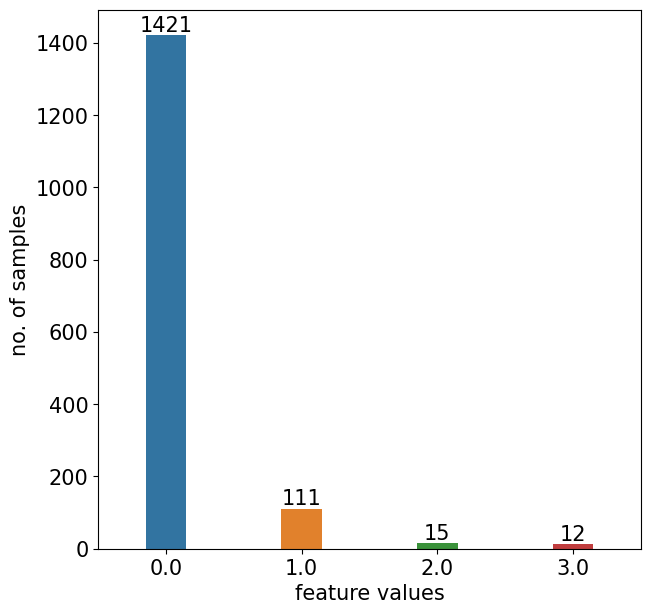

In [26]:
#Synthetic
imp_feat2, index_list =feature_selection(sampled_discrete_class2)
ind2 = index_list[0]
count_plot(sampled_discrete_class2, ind2)

### Pairwise cosine similarity of all features for real and synthetic distributions

Movie class 0

In [27]:
cosine_sim(movie_class0,sampled_discrete_class0)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<Axes: >

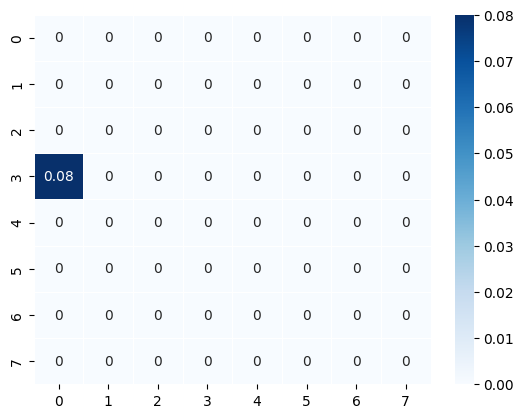

In [28]:
sns.heatmap(cosine_sim(movie_class0.iloc[:8],sampled_discrete_class0[:8]),xticklabels = 1, yticklabels = 1, 
            cmap='Blues', annot=True,linewidth=.5)

Movie class 1

In [29]:
cosine_sim(movie_class1,sampled_discrete_class1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<Axes: >

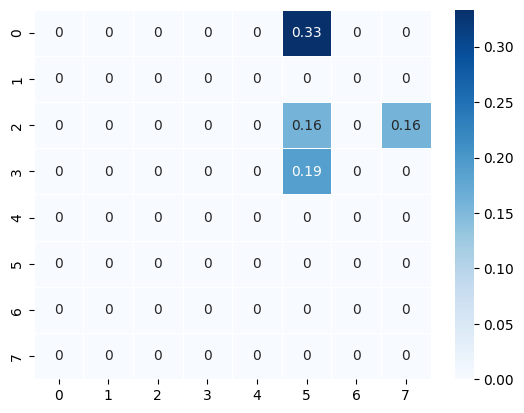

In [30]:
sns.heatmap(cosine_sim(movie_class1.iloc[:8],sampled_discrete_class1[:8]),xticklabels = 1, yticklabels = 1, 
            cmap='Blues', annot=True,linewidth=.5)

Movie class 2

In [31]:
cosine_sim(movie_class2,sampled_discrete_class2)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.35355339, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

<Axes: >

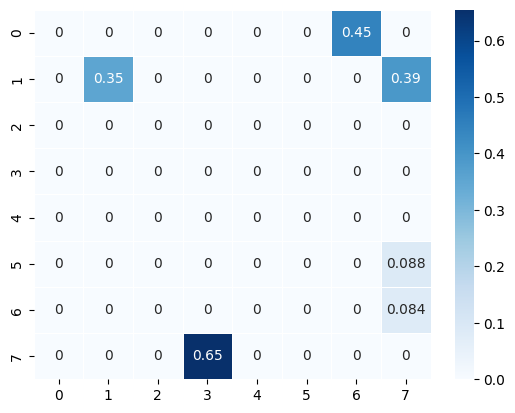

In [32]:
sns.heatmap(cosine_sim(movie_class2.iloc[:8],sampled_discrete_class2[:8]),xticklabels = 1, yticklabels = 1, 
            cmap='Blues', annot=True,linewidth=.5)